# QT-Assignment-05

by Guillaume IDAME KORALAGE

## Libraries
Let's import libraries we will need first.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import requests
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt

Run the cells below to retrieve historical data of the stocks that belong to the S&P index today.

In [2]:
def get_spy():

  url = 'https://www.slickcharts.com/sp500'
  request = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
  soup = bs(request.text, "lxml")
  stats = soup.find('table',class_='table table-hover table-borderless table-sm')
  df =pd.read_html(str(stats))[0]
  df['% Chg'] = df['% Chg'].str.strip('()-%')
  df['% Chg'] = pd.to_numeric(df['% Chg'])
  df['Chg'] = pd.to_numeric(df['Chg'])

  return df

In [3]:
sp500 = get_spy()

Run the following cell to retrieve historical data of these stocks since 2013.

In [4]:
# Fetch the list of S&P 500 components
sp500_components = sp500['Symbol'].tolist()

sp500_components.remove('KVUE')
sp500_components.remove('VLTO')
sp500_components.remove('BRK.B')
sp500_components.remove('BF.B')

# Define the time period for historical data
start_date = "2013-01-01"
end_date = "2024-01-01"

# Fetch historical stock data for all S&P 500 components
stock_data = yf.download(sp500_components, start=start_date, end=end_date)['Adj Close']


[*********************100%%**********************]  499 of 499 completed


We would like to do a simulation on a fixed pool of stocks. For that reason, remove the columns that contain missing data (for instance companies that were not listed on NYSE or Nasdaq in 2013, as Uber or Airbnb).

In [5]:
# Remove columns with missing data from the stock_data DataFrame
stock_data.dropna(axis=1, inplace=True)

In [6]:
# Check the size of the fixed pool of stocks
stock_data.shape[1]

460

## Questions

### Q1: Calculate now the timeseries of the mean daily return (i.e. averaged over all stocks).  

We calculate both the simple returns on the stock_data.

In [7]:
stock_data_returns = stock_data.pct_change().mean(axis = 1)
mean_daily_return = stock_data_returns.mean(axis = 0)
print(f'The mean daily return is {round(mean_daily_return * 100,4)}%')

The mean daily return is 0.069%


### Q2: Calculate also the daily return of the S&P500 index (using for instance the code of assignment 1).

We create a function and a few lines of code from Assignment 1 to load the GSPC (S&P 500 Index) from 2013 to 2024.

In [8]:
def get_multi_timeseries(list_underlying, interval_value, start_date, end_date):
   
    underlying_data = yf.download(list_underlying, interval = interval_value, start=start_date, end=end_date)
    
    return underlying_data

In [9]:
interval_value = "1d"
list_yahoo_code = ["^GSPC"]
start_date = "2013-01-01"
end_date = "2024-01-01"

raw_market_data = get_multi_timeseries(list_yahoo_code, interval_value, start_date, end_date)

SP500_price = raw_market_data.xs("Adj Close", axis = 1).to_frame(name = "SPX")

[*********************100%%**********************]  1 of 1 completed


In [10]:
# Calculate simple mean daily return of S&P 500 Index
SP500_daily_returns = SP500_price.pct_change()
SP500_mean_daily_return = SP500_daily_returns.mean()
print(f'The mean daily return for the S&P 500 Index is {round(SP500_mean_daily_return * 100,4)[0]}%')

The mean daily return for the S&P 500 Index is 0.0486%


### Q3: Which has a higher Sharpe ratio? What could be a probable reason for this?

Let's create a function to calculate the **annualized** Sharpe ratio and then call it on each dataframe.

In [11]:
def get_sharpe_ratio(mean_returns): 
    
    sharpe_ratio = (mean_returns.mean() * 252) / (mean_returns.std() * np.sqrt(252))
    
    return sharpe_ratio

In [12]:
stock_data_sr = get_sharpe_ratio(stock_data_returns)
SP500_sr = get_sharpe_ratio(SP500_daily_returns)

print(f'stock_data SR: {round(stock_data_sr,4)}')
print(f'S&P 500 Index SR: {round(SP500_sr[0],4)}')

stock_data SR: 0.971
S&P 500 Index SR: 0.7117


The reason the sharpe ratios are different is that the SP500 is a market weighted index (i.e. the weight of each stock depends on the market capitalization). Whereas the stock_data's mean daily return supposes that each stock has equal weight.

### Q4: Construct now a data frame for a simple version of residual returns as the difference of the returns and their cross-sectional mean.

In [13]:
# Ensure both dataframes have the same length by dropping NA values from both
SP500_daily_returns_cleaned = SP500_daily_returns.dropna()
stock_data_returns_cleaned = stock_data_returns.dropna()

# Convert to DataFrame and ensure alignment by using the index of SP500_daily_returns_cleaned
stock_data_returns_df = stock_data_returns_cleaned.to_frame(name="Cross Sectional").reindex(SP500_daily_returns_cleaned.index)

# Perform subtraction operation
residuals = SP500_daily_returns_cleaned - stock_data_returns_df.values
residuals.columns = ["Residuals"]

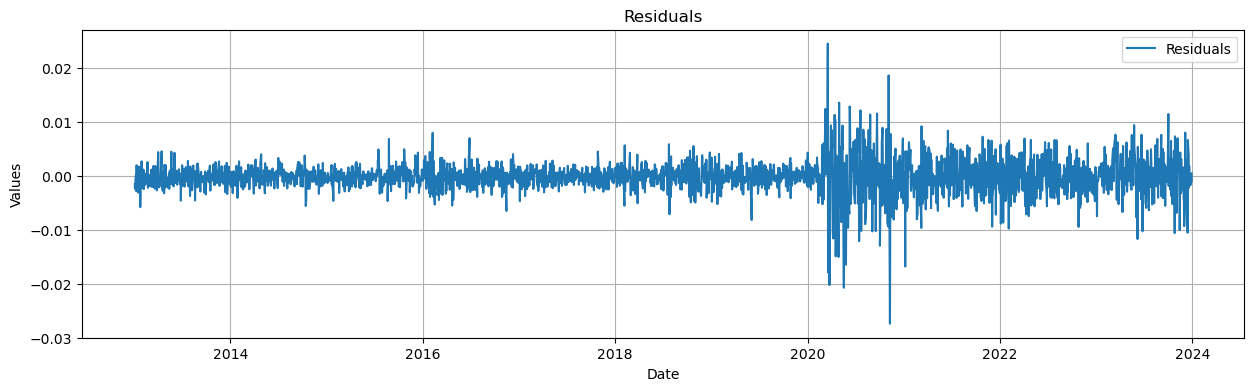

In [14]:
fig, ax = plt.subplots(figsize = (15,4))
ax.plot(residuals, label = residuals.columns[0])
ax.set_ylabel("Values")
ax.set_xlabel("Date")
ax.set_title("Residuals")
ax.grid()
ax.legend()

### Q5: Take as a predictor a rolling average of the past residuals (over 20 days) and calculate the P&L. What observations can you make?

In [15]:
rolling_residuals = residuals.rolling(20).mean().dropna()

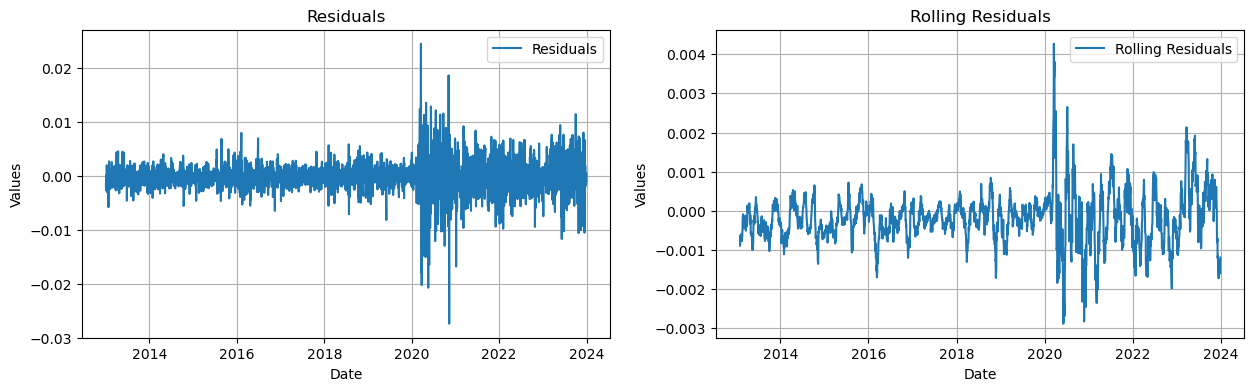

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (15,4))
axs[0].plot(residuals, label = residuals.columns[0])
axs[0].set_ylabel("Values")
axs[0].set_xlabel("Date")
axs[0].set_title("Residuals")
axs[0].grid()
axs[0].legend()

axs[1].plot(rolling_residuals, label = "Rolling Residuals")
axs[1].set_ylabel("Values")
axs[1].set_xlabel("Date")
axs[1].set_title("Rolling Residuals")
axs[1].grid()
axs[1].legend()

In [17]:
X = (residuals - rolling_residuals).dropna()
positions = (X < 0).replace({False: -1, True: 1})
strategy_daily_returns = positions.shift(1) * residuals 
strategy_cumul_returns = (1 + strategy_daily_returns).cumprod()-1

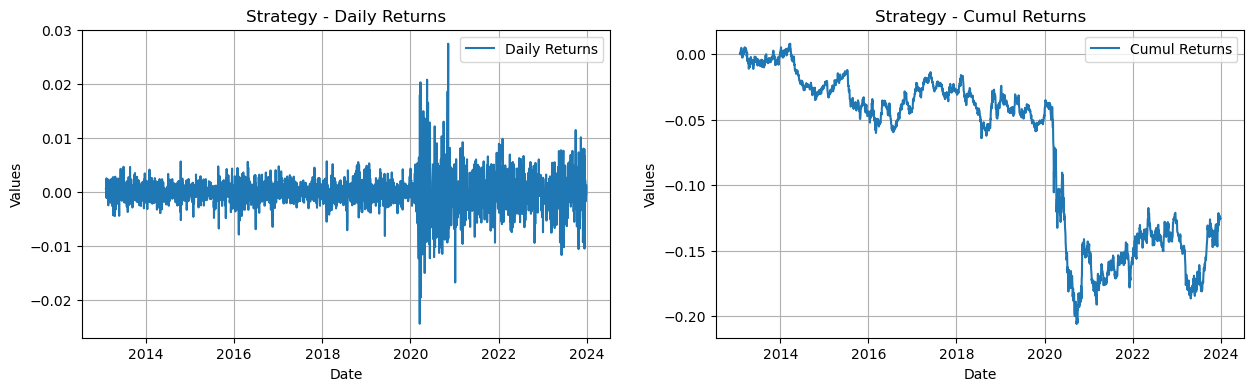

In [18]:
fig, axs = plt.subplots(1, 2, figsize = (15,4))
axs[0].plot(strategy_daily_returns, label = "Daily Returns")
axs[0].set_ylabel("Values")
axs[0].set_xlabel("Date")
axs[0].set_title("Strategy - Daily Returns")
axs[0].grid()
axs[0].legend()

axs[1].plot(strategy_cumul_returns, label = "Cumul Returns")
axs[1].set_ylabel("Values")
axs[1].set_xlabel("Date")
axs[1].set_title("Strategy - Cumul Returns")
axs[1].grid()
axs[1].legend()

**This trend following is not working and especially exposed**

### Q Bonus: How much transaction costs can the strategy support?

In [20]:
for tc in range(0,101):
    X = (residuals - rolling_residuals).dropna()
    positions = (X < 0).replace({False: -1, True: 1})

    transaction_cost = tc/(100*100)
    transaction_cost_positions = (positions.diff() * transaction_cost).abs()

    strategy_daily_returns = positions * residuals.shift(1) - transaction_cost_positions
    strategy_cumul_returns = (1 + strategy_daily_returns).cumprod()-1
    if strategy_cumul_returns.iloc[-1].values<-0.99:
        print(f"max tc supported is {tc/100} %")
        break

max tc supported is 0.18 %


In [21]:
X = (residuals - rolling_residuals).dropna()
positions = (X < 0).replace({False: -1, True: 1})

transaction_cost = 0.05/100
transaction_cost_positions = (positions.diff() * transaction_cost).abs()

strategy_daily_returns = positions * residuals.shift(1) - transaction_cost_positions
strategy_cumul_returns = (1 + strategy_daily_returns).cumprod()-1

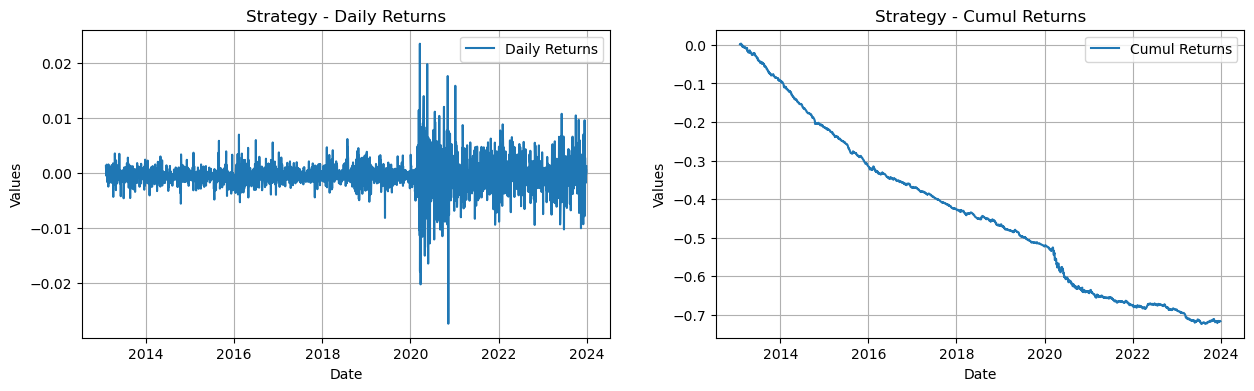

In [22]:
fig, axs = plt.subplots(1, 2, figsize = (15,4))
axs[0].plot(strategy_daily_returns, label = "Daily Returns")
axs[0].set_ylabel("Values")
axs[0].set_xlabel("Date")
axs[0].set_title("Strategy - Daily Returns")
axs[0].grid()
axs[0].legend()

axs[1].plot(strategy_cumul_returns, label = "Cumul Returns")
axs[1].set_ylabel("Values")
axs[1].set_xlabel("Date")
axs[1].set_title("Strategy - Cumul Returns")
axs[1].grid()
axs[1].legend()

**Transaction costs have a huge impacts on the cumulative returns**